# LDE Project

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import json
import pandas as pd
import seaborn as sn

In [2]:
# model parameters
R_0 = 3.49
mu = 1/2      #(mean latency period)^-1
gamma = 1/6   #(mean infectious period)^-1
beta = R_0 * gamma
gamma_H = 1/10   # (mean hospital stay)^-1
fD = 0.08
k = 1
nu = 3239/6909 #ratio from H to D n(D/H)/n(H)=3239/6909 section 3.1 April
r = 0.31
delta_c = 1e-6
D_c = 1e-4
N = 60*1e6

# initial situation in Italy
S0 = 60.352*1e6
E0 = 1695
I0 = 308.8
R0 = 311.1
H0 = 127.4
D0 = 0
N0 = E0+I0+H0+R0+S0

thrsld = 1e-5*S0/N0

z0 = np.array([S0, E0, I0, R0, H0, D0])/N0

In [4]:
# 1) permanent lockdown after reaching the threshold the first time

def myrate_hosp(t, r, t_thrsld):
    if t>=t_thrsld-1:    
        return r
    else:
        return 1
    
def mymodel_hosp(t, z, beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H  #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H
    return [dS, dE, dI, dR, dH, dD]

## awareness/no awareness

In [206]:
t_max=250
t = np.arange(t_max)

# 1) PERMANENT LOCKDOWN
#at first, we look for time instant at which the hospitalized threshold for
#lockdown is reached, then we use it in a permanent lockdown model
t_thrsld=t_max+1
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)

index = t_max+1
for i, h in enumerate(H):
    if (h>thrsld): 
        index=i
        break
        
t_thrsld = index    
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld))

S, E, I, R, H, D = sol.sol(t)
x = [S, E, I, R, H, D]

print(t_thrsld)

14


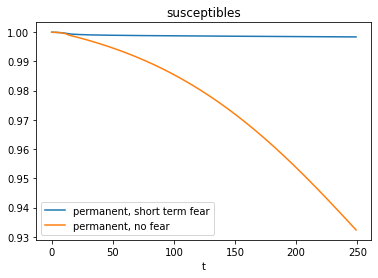

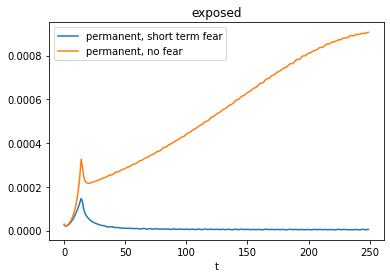

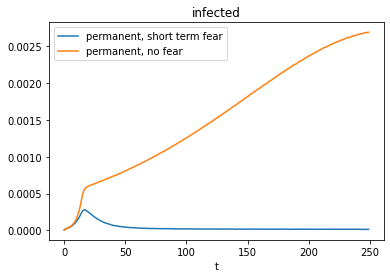

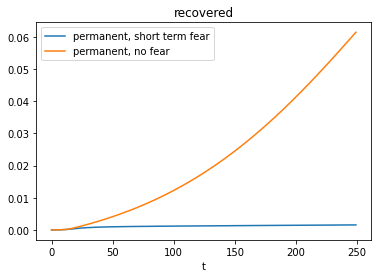

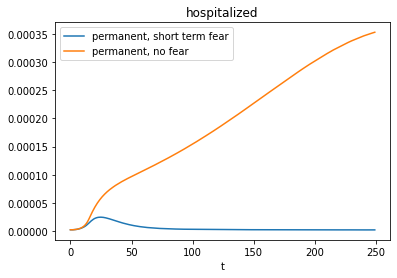

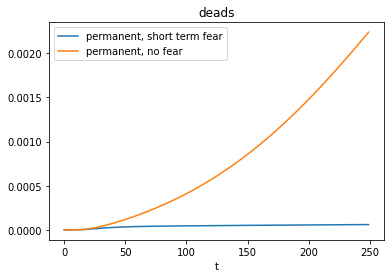

In [30]:
# no fear -> delta_c=10000
sol1 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 10000, k, nu, r, t_thrsld))

S1, E1, I1, R1, H1, D1 = sol1.sol(t)
x1 = [S1, E1, I1, R1, H1, D1]

names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col1) in enumerate(zip(x, x1)):
    plt.figure(i)
    plt.plot(t, col.T, label = 'permanent, short term fear')
    plt.plot(t, col1.T, label = 'permanent, no fear')
    plt.xlabel('t')
    plt.legend()
    plt.title(names[i])

## Parameter space: rate & $\delta_c$

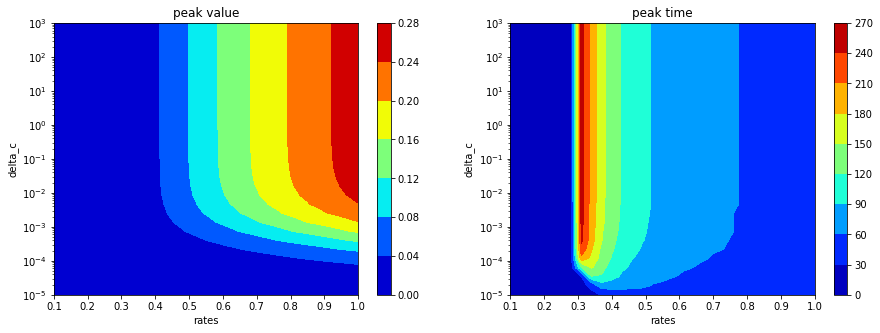

In [6]:
# change: rates & delta_c
# look at: peak values & peak times

t_max = 250
t = np.arange(t_max)

delta_c = np.logspace(-5, 3, 31) #101 PUNTI PER PLOT PIù FINE
rates = np.linspace(0.1, 1, 31)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, r, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value
        
# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values,cmap='jet')
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('delta_c')
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times,cmap='jet')
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('delta_c')
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
plt.show()

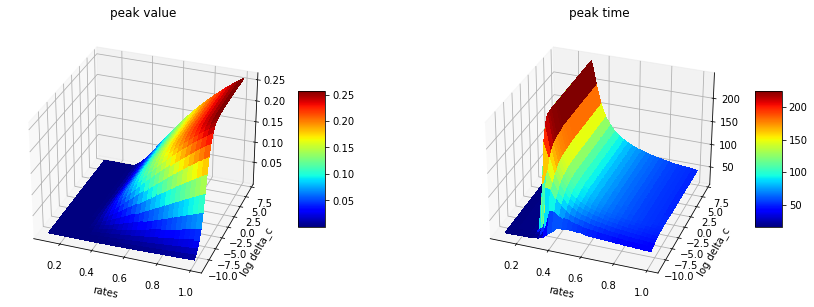

In [7]:
# 3D plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, np.log(Y), peak_values, cmap='jet',linewidth=0, antialiased=False)
ax1.view_init(30, 290)  #230
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('log delta_c')

surf2 = ax2.plot_surface(X, np.log(Y), peak_times, cmap='jet',linewidth=0, antialiased=False)
ax2.view_init(30, 290)
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('log delta_c')

fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.show()

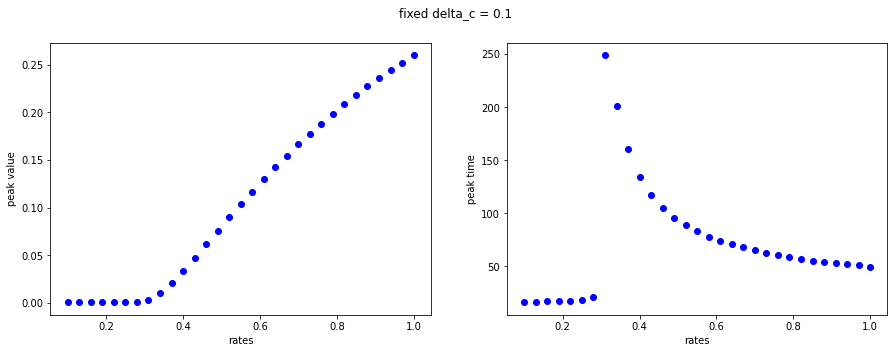

In [8]:
# fixed delta_c
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(rates, peak_values[15,:], 'bo')
ax1.set_xlabel('rates')
ax1.set_ylabel('peak value')

ax2.plot(rates, peak_times[15,:], 'bo')
ax2.set_xlabel('rates')
ax2.set_ylabel('peak time')

fig.suptitle('fixed delta_c = 0.1')
plt.show()

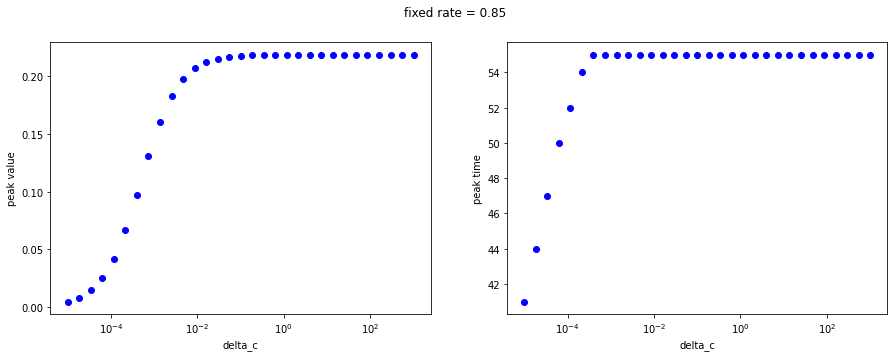

In [9]:
# fixed rate
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(delta_c, peak_values[:,25], 'bo')
ax1.set_xscale('log')
ax1.set_xlabel('delta_c')
ax1.set_ylabel('peak value')

ax2.plot(delta_c, peak_times[:,25], 'bo')
ax2.set_xscale('log')
ax2.set_xlabel('delta_c')
ax2.set_ylabel('peak time')

fig.suptitle('fixed rate = 0.85')
plt.show()

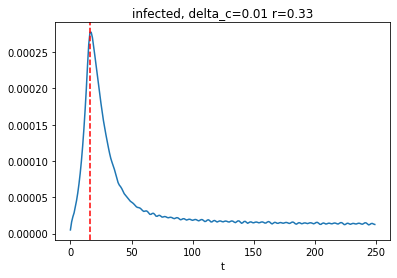

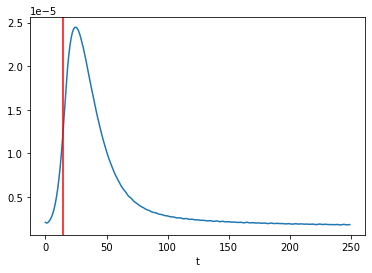

In [147]:
# example of infected dynamics

sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 1e-6, k, nu, 0.31, t_thrsld))
t = np.arange(t_max)
S, E, I, R, H, D = sol.sol(t)
peak_time = np.argmax(I)
peak_time

# plot
plt.plot(t,I)
plt.axvline(peak_time, color='r', linestyle='--',label='peak')
plt.title('infected, delta_c=0.01 r=0.33')
plt.xlabel('t')
plt.show()

plt.plot(t,H)
plt.axvline(14, color = 'red')
plt.xlabel('t')
plt.show()

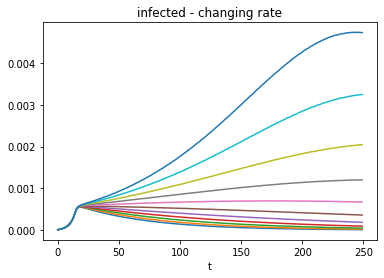

In [11]:
# infected dynamics
# changing rates

delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)

Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing rate')
plt.show()

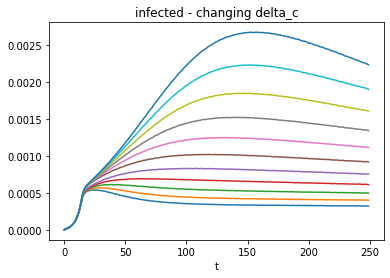

In [12]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 11)
rates = 0.35

Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, rates, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing delta_c')
plt.show()

## Parameter $k = 4$

In [13]:
k1 = 4

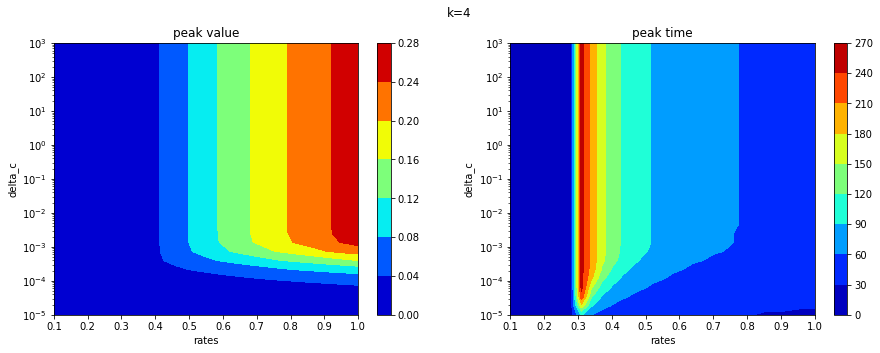

In [14]:
# change: rates & delta_c
# look at: peak values & peak times

t_max = 250
t = np.arange(t_max)

delta_c = np.logspace(-5, 3, 31)
rates = np.linspace(0.1, 1, 31)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k1, nu, r, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value

# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values, cmap='jet')
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('delta_c')
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times, cmap='jet')
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('delta_c')
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
fig.suptitle('k=4')
plt.show()

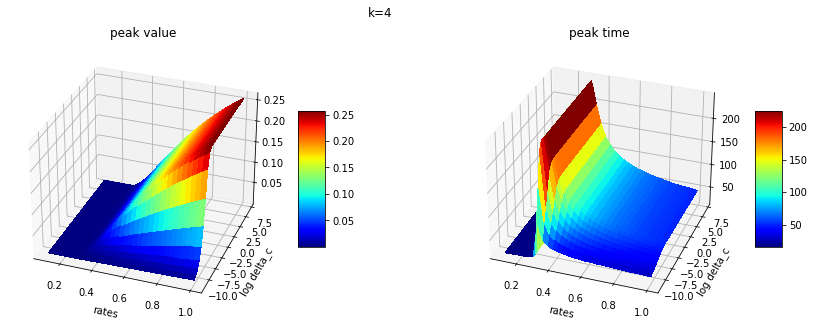

In [15]:
# 3D plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, np.log(Y), peak_values, cmap='jet',linewidth=0, antialiased=False)
ax1.view_init(30, 290)  #230
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('log delta_c')

surf2 = ax2.plot_surface(X, np.log(Y), peak_times, cmap='jet',linewidth=0, antialiased=False)
ax2.view_init(30, 290)
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('log delta_c')

fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
fig.suptitle('k=4')
plt.show()

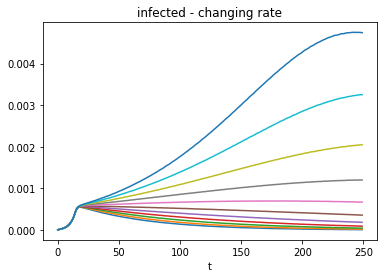

In [16]:
# infected dynamics
# changing rates

delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)

Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k1, nu, r, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing rate')
plt.show()

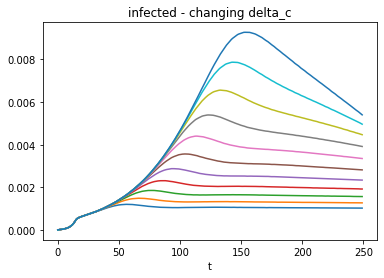

In [17]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 11)
rates = 0.35

Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k1, nu, rates, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing delta_c')
plt.show()

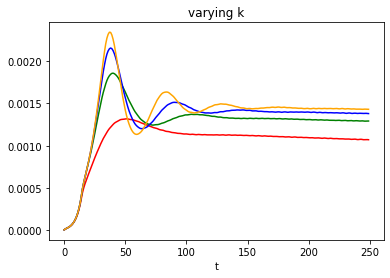

In [18]:
d = 1e-5
rate = 0.5
ks = [1,2,3,4]

sol1 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 1, nu, rate, t_thrsld))
I1 = sol1.sol(t)[2]
sol2 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 2, nu, rate, t_thrsld))
I2 = sol2.sol(t)[2]
sol3 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 3, nu, rate, t_thrsld))
I3 = sol3.sol(t)[2]
sol4 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 4, nu, rate, t_thrsld))
I4 = sol4.sol(t)[2]

plt.plot(t,I1, color = 'red')
plt.plot(t,I2, color = 'green')
plt.plot(t,I3, color = 'blue')
plt.plot(t,I4, color = 'orange')
plt.xlabel('t')
plt.title('varying k')
plt.show()

$\delta_c$ deve essere circa 10**-5


Con $r<0.3$ non si vede differenza tra diversi valori di $k$.

## short/long term awareness

In [19]:
# 2) long term fear

def long_term_fear(t, z, beta, mu, gamma, fD, delta_c, D_c, k, nu, r, t_thrsld):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k + (D/D_c)**k)
    dE = beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k + (D/D_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H   #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H  
    return [dS, dE, dI, dR, dH, dD]

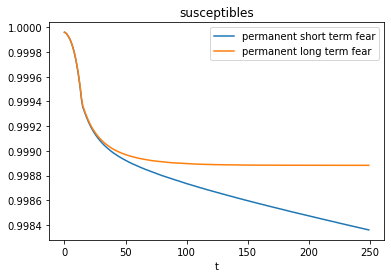

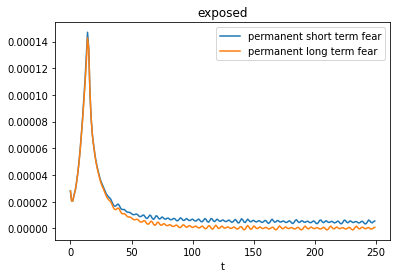

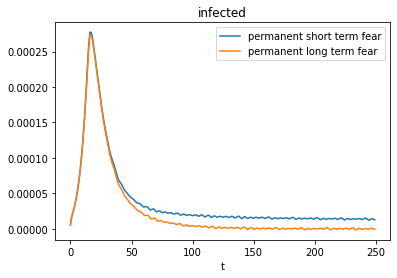

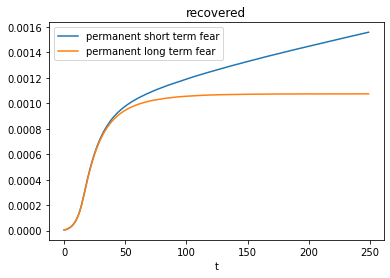

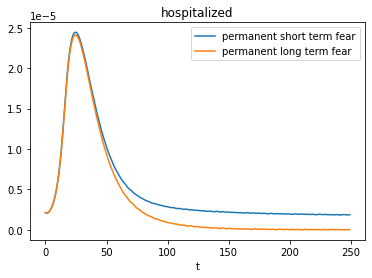

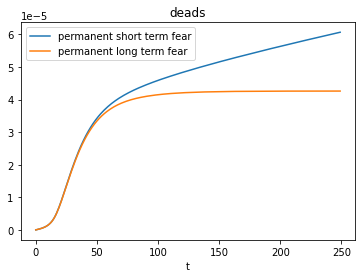

In [21]:
# 2) LONG TERM AWARENESS
k = 1
delta_c = 1e-6
sol2 = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, D_c, k, nu, r, t_thrsld))

S2, E2, I2, R2, H2, D2 = sol2.sol(t)
x2 = [S2, E2, I2, R2, H2, D2 ]

names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col2) in enumerate(zip(x, x2)):
    plt.figure(i)
    plt.plot(t, col.T, label = 'permanent short term fear')
    plt.plot(t, col2.T, label = 'permanent long term fear')
    plt.xlabel('t')
    plt.legend()
    plt.title(names[i])

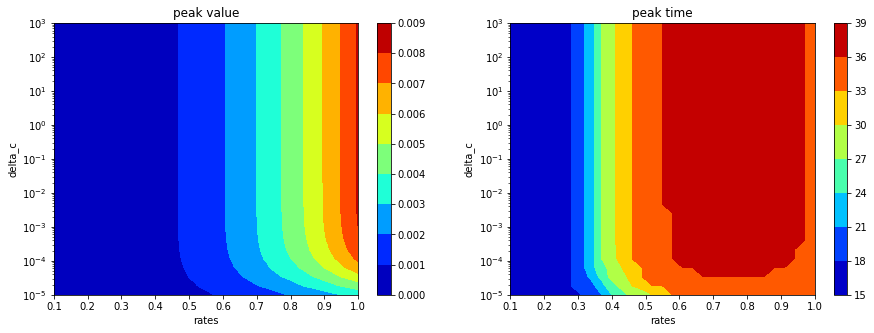

In [22]:
t_max = 250
t = np.arange(t_max)

delta_c = np.logspace(-5, 3, 31) #101 PUNTI PER PLOT PIù FINE
rates = np.linspace(0.1, 1, 31)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, D_c, k, nu, r, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value
        
# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values,cmap='jet')
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('delta_c')
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times,cmap='jet')
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('delta_c')
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
plt.show()

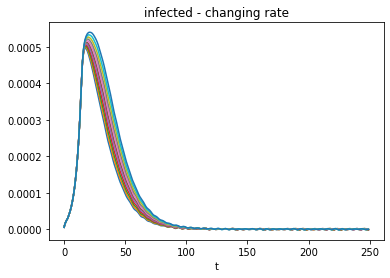

In [23]:
# infected dynamics
# changing rates

delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)

Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, D_c, k, nu, r, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing rate')
plt.show()

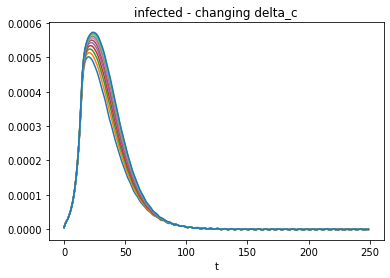

In [24]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 11)
rates = 0.35

Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, D_c, k, nu, rates, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing delta_c')
plt.show()

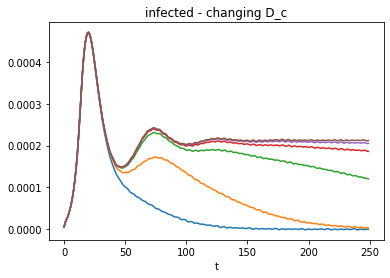

In [51]:
delta_c = 1e-6
rates = 0.8
D_cs = [5e-5, 1e-4, 2.5e-4, 5e-4, 10e-4, 1]

Is = np.zeros(shape=(len(D_cs), t_max))
for i,DD in enumerate(D_cs):
    sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, DD, 2, nu, rates, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing D_c')
plt.show()

## permanent/intermittent lockdown

In [361]:
# model parameters
R_0 = 3.49
mu = 1/2      #(mean latency period)^-1
gamma = 1/6   #(mean infectious period)^-1
beta = R_0 * gamma
gamma_H = 1/10   # (mean hospital stay)^-1
fD = 0.08
k = 1
nu = 3239/6909 #ratio from H to D n(D/H)/n(H)=3239/6909 section 3.1 April
r = 0.3
delta_c = 1e-5
D_c = 1e-4
N = 60*1e6

# initial situation in Italy
S0 = 60.352*1e6
E0 = 1695
I0 = 308.8
R0 = 311.1
H0 = 127.4
D0 = 0
N0 = E0+I0+H0+R0+S0

thrsld = 1e-5*S0/N0

z0 = np.array([S0, E0, I0, R0, H0, D0])/N0

In [362]:
# 1) permanent lockdown after reaching the threshold the first time

def myrate_hosp(t, r, t_thrsld):
    if t>=t_thrsld-1:    
        return r
    else:
        return 1
    
def mymodel_hosp(t, z, beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H  #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H
    return [dS, dE, dI, dR, dH, dD]

t_max=250
t = np.arange(t_max)

t_thrsld=t_max+1
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, t_eval = t, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)

index = t_max+1
for i, h in enumerate(H):
    if (h>thrsld): 
        index=i
        break
        
t_thrsld = index    
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, t_eval = t, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld))

S, E, I, R, H, D = sol.sol(t)
x = [S, E, I, R, H, D]

print(t_thrsld)

12


In [363]:
# 3) intermittent lockdown when reaching the threshold

def lockdown(H, r, thrsld):
    if H > thrsld:
        return r
    else:
        return 1

def lockdown_model(t, z, beta, mu, gamma, fD, delta_c, k, nu, r, thrsld):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*lockdown(H, r, thrsld)/(1+(dD/delta_c)**k)
    dE = beta*S*I*lockdown(H, r, thrsld)/(1+(dD/delta_c)**k) - mu*E
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H
    dH = fD*gamma*I - gamma_H*H      
    return [dS, dE, dI, dR, dH, dD]

In [364]:
# 3) INTERMITTENT LOCKDOWN

sol3 = solve_ivp(lockdown_model, [0,t_max], z0, t_eval = t, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, thrsld))
S3, E3, I3, R3, H3, D3 = sol3.sol(t)
x3 = [S3, E3, I3, R3, H3, D3]

In [365]:
for i, h in enumerate(H3):
    if (h>thrsld): 
        index=i
        break

print(index)

12


In [366]:
b1 = []
b2 = []
for i, h in zip(t, H3):
    b1.append(myrate_hosp(i, r, t_thrsld))
    b2.append(lockdown(h, r, thrsld))
    print(i, myrate_hosp(i, r, t_thrsld), lockdown(h, r, thrsld))

0 1 1
1 1 1
2 1 1
3 1 1
4 1 1
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 1 1
11 0.3 1
12 0.3 0.3
13 0.3 0.3
14 0.3 0.3
15 0.3 0.3
16 0.3 0.3
17 0.3 0.3
18 0.3 0.3
19 0.3 0.3
20 0.3 0.3
21 0.3 0.3
22 0.3 0.3
23 0.3 0.3
24 0.3 0.3
25 0.3 0.3
26 0.3 0.3
27 0.3 0.3
28 0.3 0.3
29 0.3 0.3
30 0.3 0.3
31 0.3 0.3
32 0.3 0.3
33 0.3 0.3
34 0.3 0.3
35 0.3 0.3
36 0.3 0.3
37 0.3 0.3
38 0.3 0.3
39 0.3 0.3
40 0.3 0.3
41 0.3 0.3
42 0.3 0.3
43 0.3 0.3
44 0.3 0.3
45 0.3 0.3
46 0.3 0.3
47 0.3 0.3
48 0.3 0.3
49 0.3 0.3
50 0.3 0.3
51 0.3 0.3
52 0.3 0.3
53 0.3 0.3
54 0.3 0.3
55 0.3 0.3
56 0.3 0.3
57 0.3 0.3
58 0.3 0.3
59 0.3 0.3
60 0.3 0.3
61 0.3 0.3
62 0.3 0.3
63 0.3 0.3
64 0.3 0.3
65 0.3 0.3
66 0.3 0.3
67 0.3 0.3
68 0.3 0.3
69 0.3 0.3
70 0.3 0.3
71 0.3 0.3
72 0.3 0.3
73 0.3 0.3
74 0.3 0.3
75 0.3 0.3
76 0.3 0.3
77 0.3 0.3
78 0.3 0.3
79 0.3 0.3
80 0.3 0.3
81 0.3 0.3
82 0.3 0.3
83 0.3 0.3
84 0.3 0.3
85 0.3 0.3
86 0.3 0.3
87 0.3 0.3
88 0.3 0.3
89 0.3 0.3
90 0.3 0.3
91 0.3 0.3
92 0.3 0.3
93 0.3 0.3
94 0.3 0.3
95 0.3 0.3


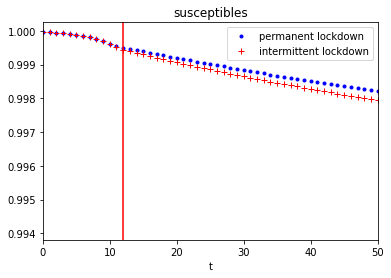

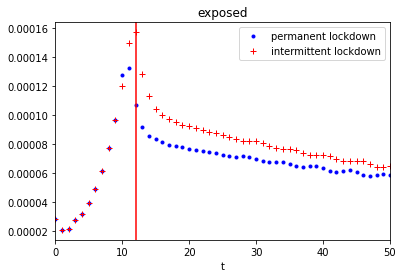

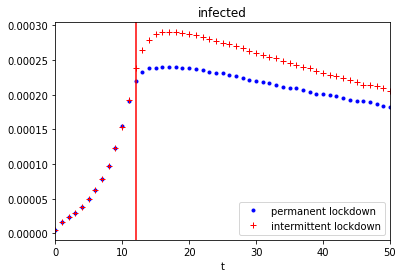

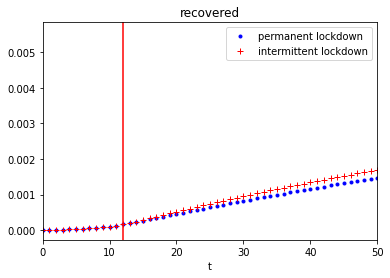

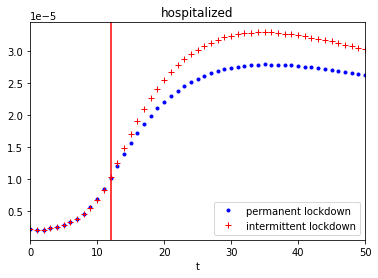

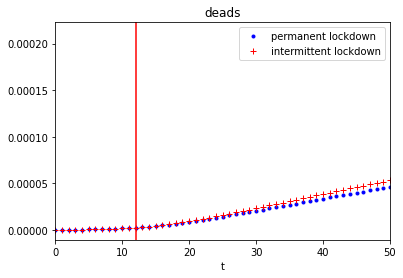

In [367]:
names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col3) in enumerate(zip(x, x3)):
    plt.figure(i)
    plt.plot(t, col.T, 'b.', label = 'permanent lockdown')
    plt.plot(t, col3.T, 'r+', label = 'intermittent lockdown')
    plt.axvline(t_thrsld, color='red')
    plt.xlabel('t')
    plt.xlim(0,50)
    plt.legend()
    plt.title(names[i])

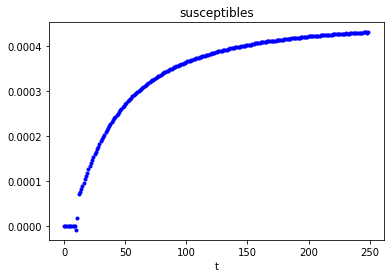

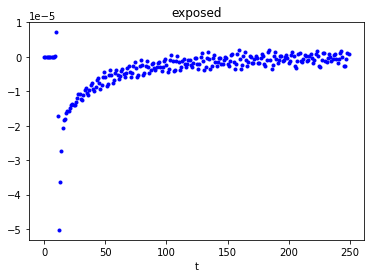

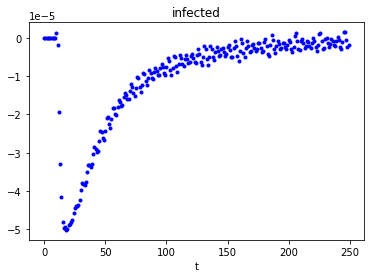

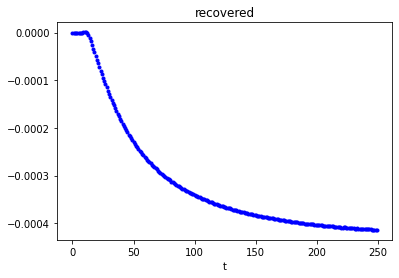

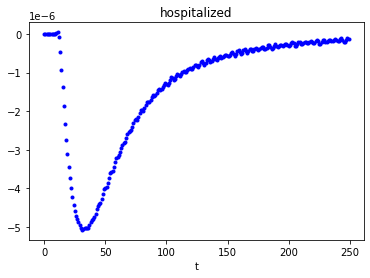

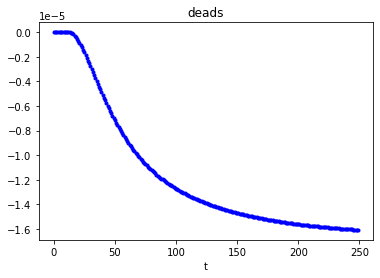

In [368]:
pltnames = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col3) in enumerate(zip(x, x3)):
    plt.figure(i)
    plt.plot(t, col.T-col3.T, 'b.')
    plt.xlabel('t')
    plt.title(names[i])

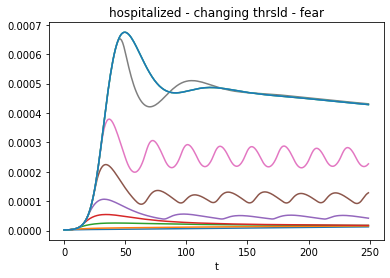

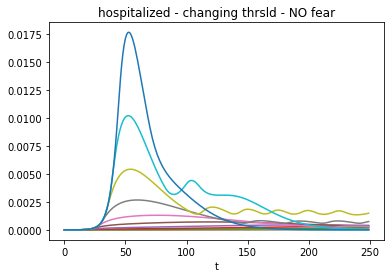

In [308]:
# change threshold
thrsld_vctr = np.logspace(-6, -2, 11)

Hs = np.zeros(shape=(11, t_max))
Hs1 = np.zeros(shape=(11, t_max))

for i,thrsld in enumerate(thrsld_vctr):
    # with fear
    sol = solve_ivp(lockdown_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu,  0.31, thrsld))
    # without fear
    sol1 = solve_ivp(lockdown_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 1000, k, nu,  0.31, thrsld))
    S, E, I, R, H, D = sol.sol(t)
    S1, E1, I1, R1, H1, D1 = sol1.sol(t)
    Hs[i,:]=H
    Hs1[i,:]=H1
    
plt.plot(t,Hs.T)
plt.title('hospitalized - changing thrsld - fear')
plt.xlabel('t')
plt.show()
plt.plot(t,Hs1.T)
plt.title('hospitalized - changing thrsld - NO fear')
plt.xlabel('t')
plt.show()

Con paura non si va oltre 10^-5, quindi lockdown non scatta, ma vediamo il plateau\
Senza paura la dinamica è libera e spazia su diversi ordini di grandezza che vengono smorzati dal relativo lockdown

In [13]:
"""# total population plot
N = N0*(S+E+I+R+H)
N2 = N0*(S2+E2+I2+R2+H2)

plt.plot(t,N,label='1 step')
plt.plot(t,N2,label='2 step')
plt.title('total population')
plt.xlabel('t')
plt.legend()
plt.show()"""

"# total population plot\nN = N0*(S+E+I+R+H)\nN2 = N0*(S2+E2+I2+R2+H2)\n\nplt.plot(t,N,label='1 step')\nplt.plot(t,N2,label='2 step')\nplt.title('total population')\nplt.xlabel('t')\nplt.legend()\nplt.show()"